# Predicting Employment Opportunities for Disabled Individuals in the United States

> Dataset: [Current Population Survey, July 2019: Disability Supplement](https://api.census.gov/data/2019/cps/disability/jul.html)
* The universe consists of all persons in the civilian non-institutional population of the United States living in households. 
* The probability sample selected to represent the universe consists of approximately 50,000 households.

## Data Preparation and Metadata
- Utilized **CensusAPI** to relevant data about employment opportunities for disable individuals
- Identified 29 relevant input variables out of the 400 in the original dataset by creating a  DAG to represent the relationship between variables

![dag.png](models/dag.png)
- Clearly defined input and output variables for the model in a [Data Dictionary](data-dictionary.csv)

## Cleaning Data
- Droped all records that are not in the universe of labor_force_employment_status
```py
filteredData = data[data["labor_force_employment_status"] != -1]
filteredData = filteredData.loc[:,  ~filteredData.columns.str.contains('^Unnamed')]
```
- Droped all records that do not have a dissability
```py
filteredData = filteredData[filteredData["does_this_person_have_any_of_these_disability_conditions"] == 1]
print(len(filteredData))
```
- Categorized output variable into binary options
```py
filteredData["labor_force_employment_status"] = filteredData["labor_force_employment_status"].apply(lambda x: 1 if x == 1 or x == 2 else 0)
```
- Final dataset is saved as `cleaned-us-data.csv`


## Analysis
> Solving a classification problem with prediction

### Option 1: Logistic Regression
- Often used for classification problems
- [Documentation](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

c:\anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1957
           1       0.94      0.82      0.88       434

    accuracy                           0.96      2391
   macro avg       0.95      0.91      0.93      2391
weighted avg       0.96      0.96      0.96      2391



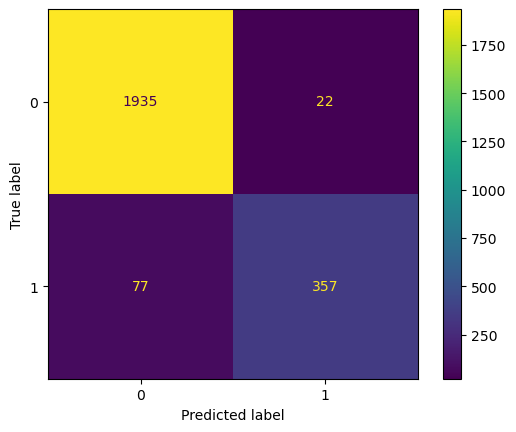

In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


data = pd.read_csv('cleaned-us-data.csv',header=0)
data = data.loc[:,  ~data.columns.str.contains('^Unnamed')]

# 80% training, 20% testing
x_var = data.loc[:, data.columns != "labor_force_employment_status"]
y_var = data.loc[:, data.columns == "labor_force_employment_status"]

X_train, X_test, y_train, y_test = train_test_split(
    x_var,
    y_var,
    test_size=0.2,
    random_state=42
)

clf_log = LogisticRegression()
clf_log = clf_log.fit(X_train, y_train)

y_pred = clf_log.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_log.classes_)
disp.plot()
print(classification_report(y_test, y_pred))
 

### Option 2: Decision Tree
- [Documentation](https://scikit-learn.org/stable/modules/tree.html)

#### Preliminary Tree
* no pruning done with default hyperparameters

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1957
           1       0.85      0.87      0.86       434

    accuracy                           0.95      2391
   macro avg       0.91      0.92      0.91      2391
weighted avg       0.95      0.95      0.95      2391



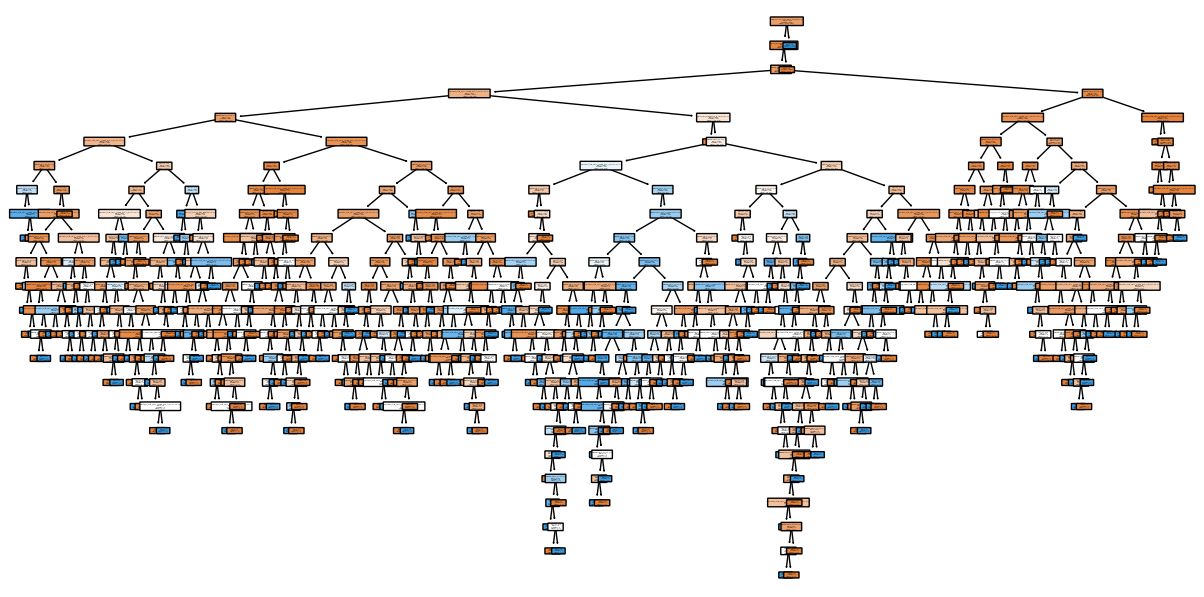

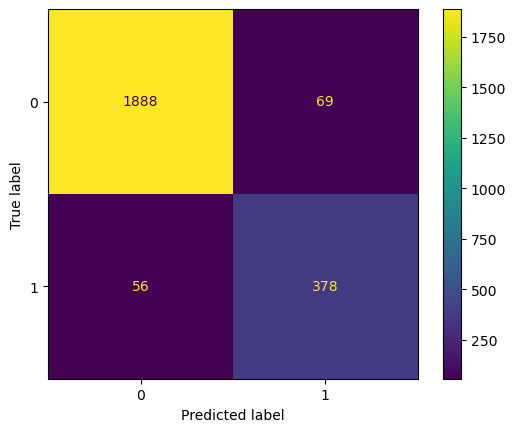

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

data = pd.read_csv('cleaned-us-data.csv',header=0)
data = data.loc[:,  ~data.columns.str.contains('^Unnamed')]

# 80% training, 20% testing
x_var = data.loc[:, data.columns != "labor_force_employment_status"]
y_var = data.loc[:, data.columns == "labor_force_employment_status"]


X_train, X_test, y_train, y_test = train_test_split(
    x_var,
    y_var,
    test_size=0.2,
    random_state=42
)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(15, 7.5))
plot_tree(clf,
          filled=True,
          rounded=True,
          class_names=["Unemployed", "Employed"],
          feature_names=x_var.columns,
        )


y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
print(classification_report(y_test, y_pred))
 

#### Pruning the decision tree
- Clearly the model is overfitting and tree size is too large
- Need to optimize the tree based off results of the confusion matrix

##### Potential Stategies
- Need to find the right value for the pruning parameter `alpha` which controls how little or how much pruning takes place. 
- One way to find optimal alpha is to plot accuracy of the tree as a function of different values -> this is known as **cost complexity pruning**
- Also need to utilize **cross validation** to ensure that alpha value isn't sensitive to a particular dataset.

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score


path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1] # exclude maximum value for alpha because it is a trivial case

# array to store results of each fold during cross validation
alpha_loop_values = []

# For each candidate for alpha, run a 5-fold cross validation and store the mean, std, and accuracy in alpha_loop_variables
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

# graph means and std of scores for each alpha value
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   yerr='std',
                   marker='o',
                   linestyle='--')

# calcualte ideal alpha
ideal_ccp_alpha = alpha_results[
    (alpha_results['alpha'] > 0.000) & (alpha_results['alpha'] < 0.002)
].sort_values('mean_accuracy', ascending=False).iloc[0]['alpha']

print(ideal)

# create new decision tree with alpha hyperparameter
clf_dt_pruned = DecisionTreeClassifier(random_state=42,
                                       ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

y_pred = clf_dt_pruned.predict(X_test)
new_cm = confusion_matrix(y_test, y_pred, labels=clf_dt_pruned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=new_cm, display_labels=clf_dt_pruned.classes_)
disp.plot()
print(classification_report(y_test, y_pred))

# Plot the pruned tree
plt.figure(figsize=(100, 60))
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["Unemployed", "Employed"],
          feature_names=x_var.columns,
        )

NameError: name 'cross_val_score' is not defined

### Option 3: Random Forrest
- Utilize several random decision trees to for more accurate predictions
- [Documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

c:\anaconda\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1957
           1       0.95      0.82      0.88       434

    accuracy                           0.96      2391
   macro avg       0.96      0.91      0.93      2391
weighted avg       0.96      0.96      0.96      2391



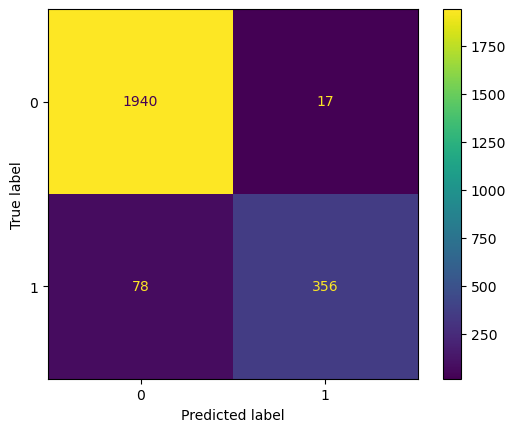

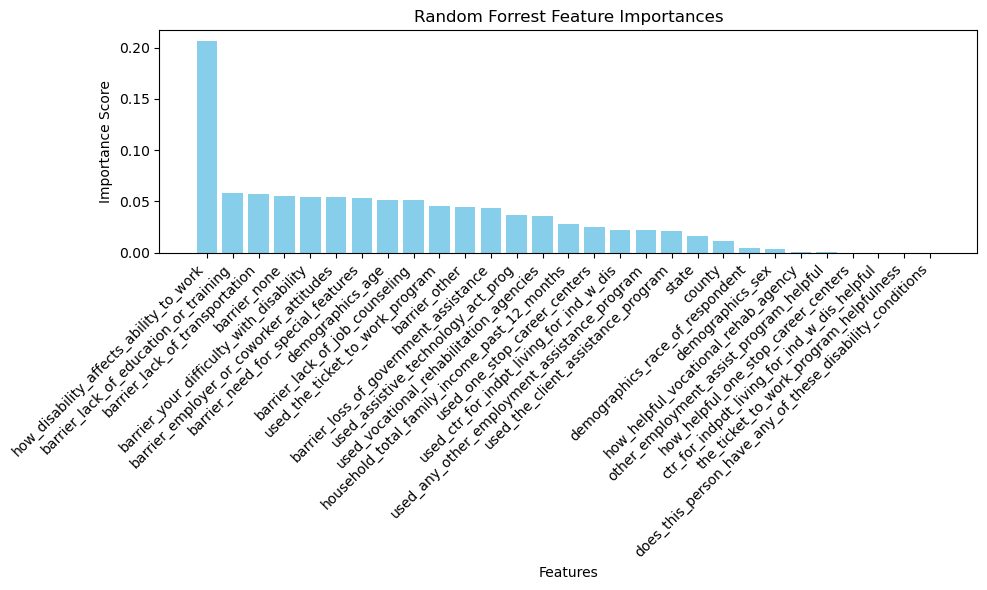

In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('cleaned-us-data.csv',header=0)
data = data.loc[:,  ~data.columns.str.contains('^Unnamed')]

# 80% training, 20% testing
x_var = data.loc[:, data.columns != "labor_force_employment_status"]
y_var = data.loc[:, data.columns == "labor_force_employment_status"]

X_train, X_test, y_train, y_test = train_test_split(
    x_var,
    y_var,
    test_size=0.2,
    random_state=42
)

# adding hyper parameters
clf_rf = RandomForestClassifier(n_estimators=1000,
                             criterion='entropy',
                             min_samples_split=10,
                             max_depth=14,
                             random_state=42)
clf_rf.fit(X_train, y_train)

y_pred = clf_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf.classes_)
disp.plot()
print(classification_report(y_test, y_pred))

feature_importances = clf_rf.feature_importances_
feature_names = list(X_train.columns)

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]
sorted_features = [feature_names[i] for i in sorted_indices]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importances, color='skyblue')
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Random Forrest Feature Importances")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Option 4: Neural Network Classifier
- Train a single layer perceptron (270 neurons and ReLU activation) on 1000 epochs
- [Documentation](https://pedromarquez.dev/blog/2022/10/pytorch-classification)


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

data = pd.read_csv('cleaned-us-data.csv',header=0)
data = data.loc[:,  ~data.columns.str.contains('^Unnamed')]

# 80% training, 20% testing
x_var = data.loc[:, data.columns != "labor_force_employment_status"]
y_var = data.loc[:, data.columns == "labor_force_employment_status"]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_var)
y_var = y_var.values.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    x_scaled,
    y_var,
    test_size=0.2,
    random_state=42
)

input_features = X_train.shape[1]

class Net(nn.Module):

    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 270)
        self.fc2 = nn.Linear(270, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.dropout(x, p=0.1)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)

        return x

net = Net(input_features)

"""
Training Parameters
- Batch size is 50 to avoid overfitting, Training for 50 epochs with learning rate of 0.01
- Use Cross entropy loss function to calculate error during training (commonly used for binary classification)
- Use Adam optimizer to find gradients
"""

# Hyper parameters:
batch_size = 50
num_epochs = 1000
learning_rate = 0.01
batch_no = len(X_train) // batch_size

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    if epoch % 50 == 0:
        print('Epoch {}'.format(epoch+1))

    # Shufle the datasets to randomize the data rows that
    # will be added to the batch and avoid training over the same 50 rows
    # at each epoch
    X_train, y_train = shuffle(X_train, y_train)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size

        x_var = torch.FloatTensor(X_train[start:end])
        y_var = torch.LongTensor(y_train[start:end])

        optimizer.zero_grad()

        # Run a training step: Pass the training data to
        # the neural network layers
        ypred_var = net(x_var)

        loss =criterion(ypred_var, y_var)

        loss.backward()
        optimizer.step()

validation_data = torch.FloatTensor(X_test)
validation_labels = torch.LongTensor(y_test)

# Predict on test data
net.eval()
with torch.no_grad():
    result = net(validation_data)
    
    _, predicted = torch.max(result, 1)
    predicted_numpy = predicted.numpy()


print(classification_report(y_test, predicted_numpy))
cm = confusion_matrix(y_test, predicted_numpy)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Choropleth Map

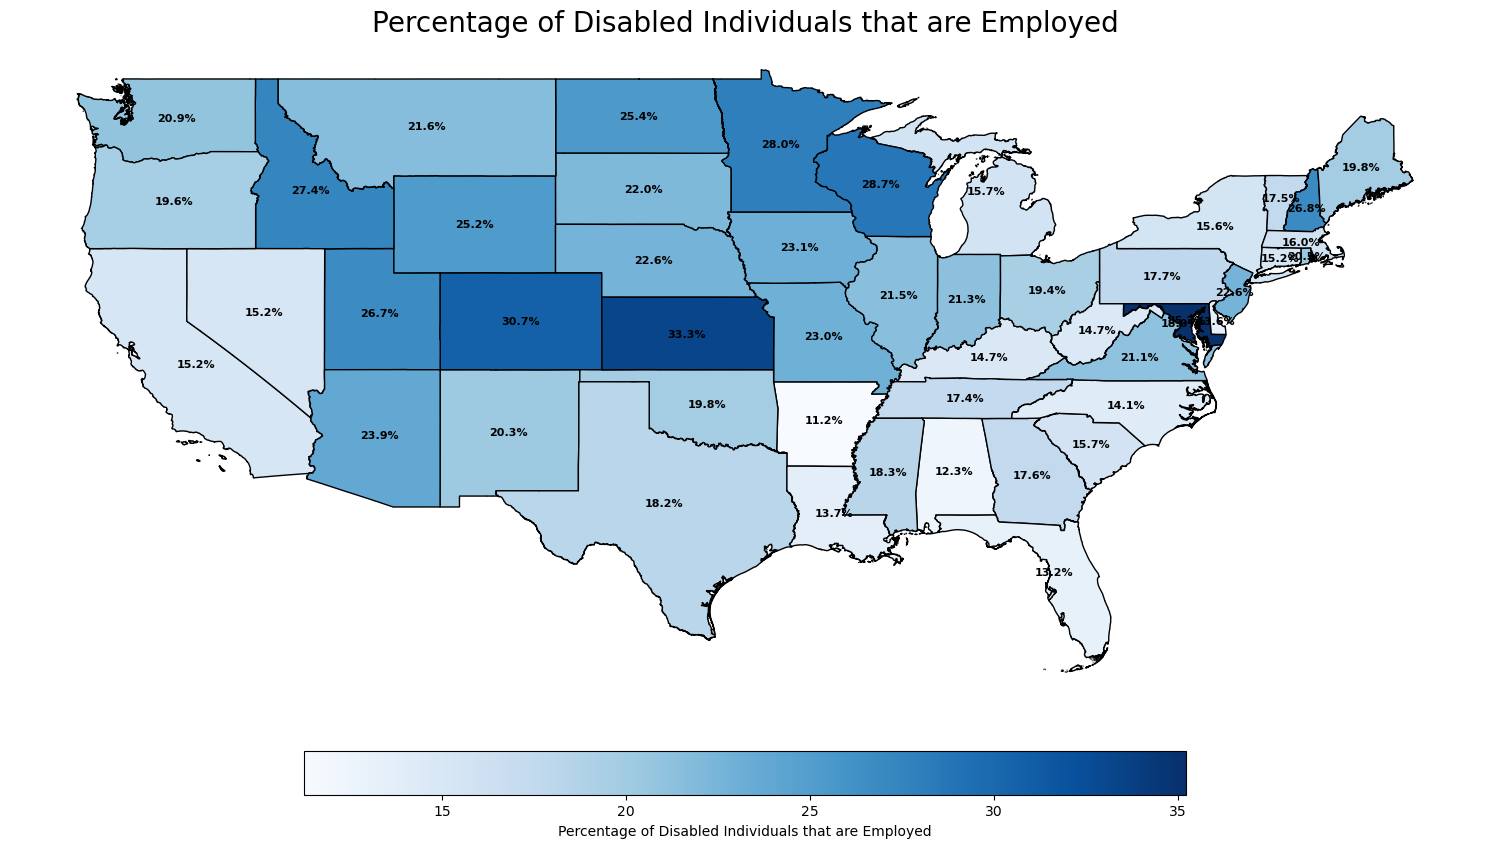

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv('cleaned-us-data.csv',header=0)
data = data.loc[:,  ~data.columns.str.contains('^Unnamed')]
us_states = gpd.read_file('models/cb_2023_us_state_500k/cb_2023_us_state_500k.shp')

total_counts = data.groupby("state").size().reset_index(name="total_disabled")
employed_counts = data[data["labor_force_employment_status"] == 1].groupby("state").size().reset_index(name="employed_disabled")
employment_counts = pd.merge(employed_counts, total_counts, on="state", how="outer")
employment_counts["employed_percentage"] = (employment_counts["employed_disabled"] / employment_counts["total_disabled"]) * 100
employment_data = pd.DataFrame({
    "STATEFP": employment_counts["state"].apply(lambda x: f"{int(x):02d}") ,
    "employed_percentage": employment_counts["employed_percentage"]
})
us_states = us_states.merge(employment_data, on="STATEFP", how="left")
us_states = us_states[
    (us_states["STATEFP"].astype(int) != 2) &
    (us_states["STATEFP"].astype(int) != 15)
]

fig, ax = plt.subplots(figsize=(15, 10))
us_states.plot(
    column="employed_percentage",
    cmap="Blues",
    legend=True,
    legend_kwds={
        "label": "Percentage of Disabled Individuals that are Employed",
        "shrink": 0.6,
        "orientation": "horizontal",
        "pad": 0.05
    },
    edgecolor="black",
    ax=ax
)

for idx, row in us_states.iterrows():
    if pd.notna(row['employed_percentage']):
        centroid = row['geometry'].centroid
        
        percentage = round(row['employed_percentage'], 1)
        
        plt.annotate(f'{percentage}%', 
                     (centroid.x, centroid.y), 
                     ha='center', 
                     va='center', 
                     fontsize=8,
                     fontweight='bold')

ax.set_title("Percentage of Disabled Individuals that are Employed", fontsize=20)
ax.axis("off")

# Display the map
plt.tight_layout()
plt.show()